# IFU maps
This notebook reads in the IOFU maps from Czoske, Barnabe et al. 2012 https://ui.adsabs.harvard.edu/abs/2012MNRAS.419..656C/abstract
and computes radial gradients.

Author: Simon Birrer

In [1]:
from hierarc.Util import ifu_util

from astropy.io import fits
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
dir_path = os.getcwd()

# path to folder with IFU data
ifu_folder = 'IFU_data/Barnabe2011-kinmaps2'
path2ifu = os.path.join(dir_path, ifu_folder)

# path to plotting directory
plot_dir = 'IFU_data/Plots/'

# file containing all the information about the sample including lens model parameters from imaging data
file_name_param_catalogue = 'slacs_all_params.csv'
file_name_catalogue = os.path.join(dir_path, file_name_param_catalogue)

In [3]:



def display_map(file_name, theta_E, r_eff, fiber_scale, r_bins, r_bins_2=None, verbose=False, save_plot=False):
    """
    :param name: string, name of lens
    """
    hdul = fits.open(file_name)
    #hdul.info()
    #print(hdul[1].header)
    if verbose:
        hdul.info()
        print(hdul[0].header)
        print(hdul[1].header)
    velocity = hdul[1].data
    dispersion = hdul[2].data
    surface_brightness = hdul[3].data
    sn_ration = hdul[4].data
    d_v_low = hdul[5].data
    d_v_high = hdul[6].data
    d_v_mean = (d_v_high - d_v_low) / 2
    d_sigma_low = hdul[7].data
    d_sigma_high = hdul[8].data
    d_sigma_mean = (d_sigma_high - d_sigma_low) / 2
    goodness_fit = hdul[9].data
    
    disp_r, weight_r = ifu_util.binned_dispersion(dispersion, weight_map=1./d_sigma_mean**2, flux_map=surface_brightness, fiber_scale=fiber_scale, r_bins=r_bins)
    disp_v, weight_r_v = ifu_util.binned_velocity(velocity, 1./d_v_mean**2, surface_brightness, fiber_scale=fiber_scale, r_bins=r_bins)

    if r_bins_2 is not None:
        disp_tot_2, error_tot_2 = ifu_util.binned_total(dispersion, weight_map_disp=1./d_sigma_mean**2, velocity_map=velocity, 
                              weight_map_v=1./d_v_mean**2, flux_map=surface_brightness, fiber_scale=fiber_scale, r_bins=r_bins_2)
    
    x_index, y_index = np.where(surface_brightness == np.max(surface_brightness))
    center_x, center_y = x_index[0], y_index[0]
    
    f, axes = plt.subplots(2, 4, figsize=(15, 8), sharex=False, sharey=False)
    
    ax = axes[0, 0]
    im = ax.matshow(np.log10(surface_brightness), origin='lower')
    ax.plot(center_y, center_x, '*')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'log$_{10}$ surface brightness', fontsize=15)
    
    
    ax = axes[0, 1]
    im = ax.matshow(velocity, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'velocity [km/s]', fontsize=15)
    ax.text(0.05, 0.9, name, transform=ax.transAxes, fontsize=20,
                verticalalignment='top')
    
    ax = axes[0, 2]
    im = ax.matshow(dispersion, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'velocity dispersion [km/s]', fontsize=15)
    x0, y0 = np.where(surface_brightness == np.max(surface_brightness))
    for r in r_bins_2[1:]:
        circle = plt.Circle((y0[0],x0[0]), r, color='k', fill=False)
        ax.add_artist(circle)
    
    
    disp_tot = np.sqrt(disp_v**2 + disp_r**2)  # total measured dispersion integrated over velocity and local dispersion
    weight_tot = (weight_r * disp_r**2 + weight_r_v * disp_v**2) / disp_tot**2
    ax = axes[0, 3]
    ax.errorbar((r_bins[1:] + r_bins[:-1])/2, disp_r, xerr=(r_bins[1:] - r_bins[:-1])/2, yerr=1/np.sqrt(weight_r), label=r'$<\sigma>$')
    ax.errorbar((r_bins[1:] + r_bins[:-1])/2 , disp_v, xerr=(r_bins[1:] - r_bins[:-1])/2, yerr=1/np.sqrt(weight_r_v), label=r'$\sqrt{<v^2>}$')
    ax.errorbar((r_bins[1:] + r_bins[:-1])/2, np.sqrt(disp_v**2 + disp_r**2), xerr=(r_bins[1:] - r_bins[:-1])/2, yerr=1/np.sqrt(weight_tot), label=r'$\sigma_{\rm tot}$')
    if r_bins_2 is not None:
        ax.errorbar((r_bins_2[1:] + r_bins_2[:-1])/2, disp_tot_2, xerr=(r_bins_2[1:] - r_bins_2[:-1])/2, yerr=error_tot_2, label=r'$\sigma_{\rm tot select}$')
        
    
    ax.axvline(theta_E, label=r'$\theta_E$', color='k', linestyle='--')
    ax.axvline(r_eff, label=r'$r_{\rm eff}$', color='k', linestyle='-.')
    ax.set_ylabel('velocity dispersion [km/s]', fontsize=15)
    ax.set_xlabel('distance from center [arc seconds]', fontsize=15)
    ax.legend()
    
    ax = axes[1, 0]
    im = ax.matshow(sn_ration, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'S/N ratio', fontsize=15)
    
    ax = axes[1, 1]
    im = ax.matshow(goodness_fit, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'goodness of fit', fontsize=15)
    
    ax = axes[1, 2]
    im = ax.matshow(d_sigma_mean, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'$\sigma_{\sigma}$', fontsize=15)
    
    ax = axes[1, 3]
    im = ax.matshow(d_v_mean, origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(r'$\sigma_{v}$', fontsize=15)
    
    plt.tight_layout()
    if save_plot:
        plot_filename = os.path.join(dir_path, plot_dir, name+'.pdf')
        plt.savefig(plot_filename)
    plt.show()

#display_map(name, r_bins, verbose=True)


SDSS sigma =  279.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


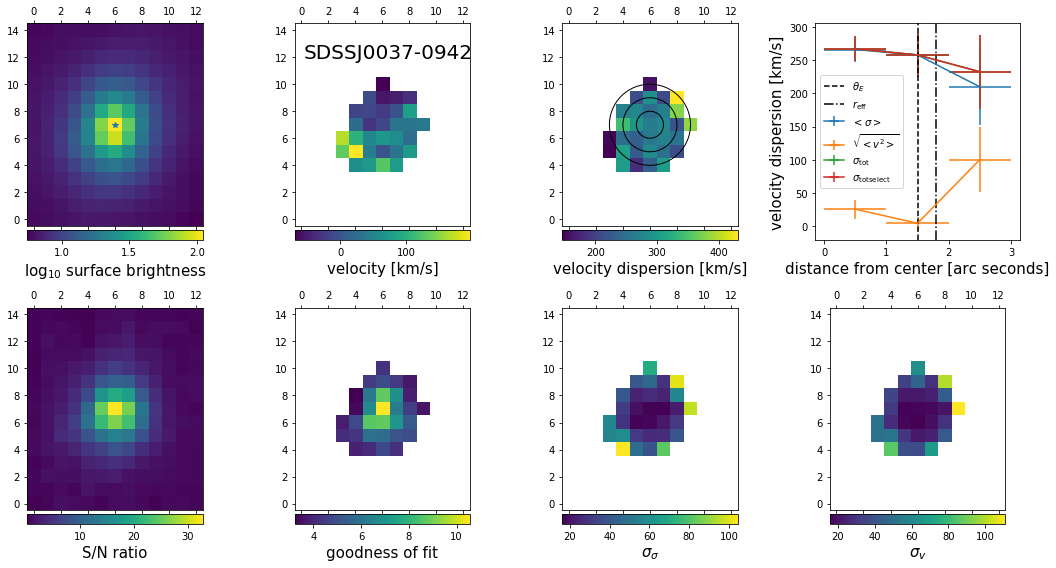

SDSS sigma =  333


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


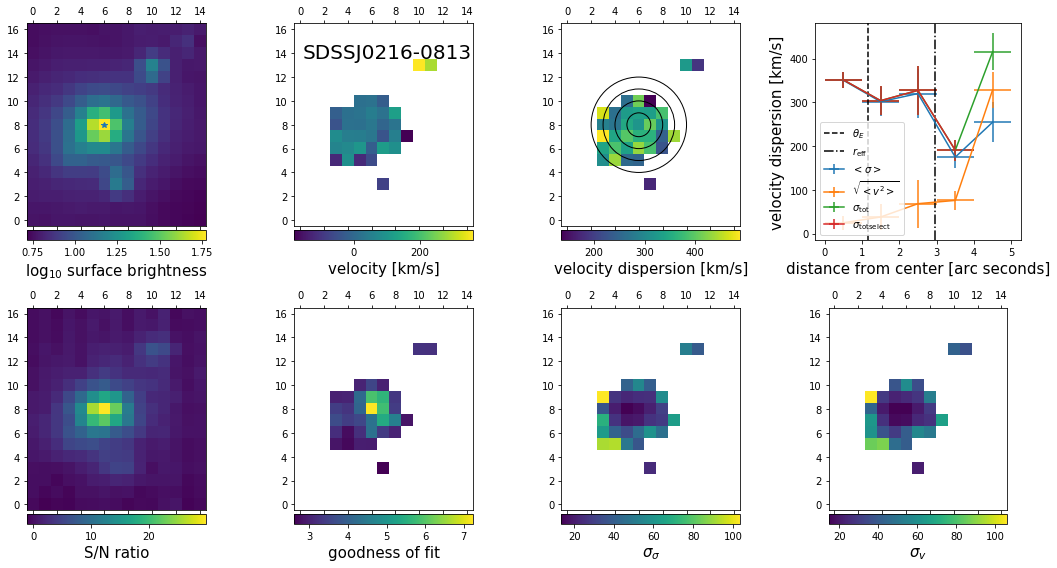

SDSS sigma =  326.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


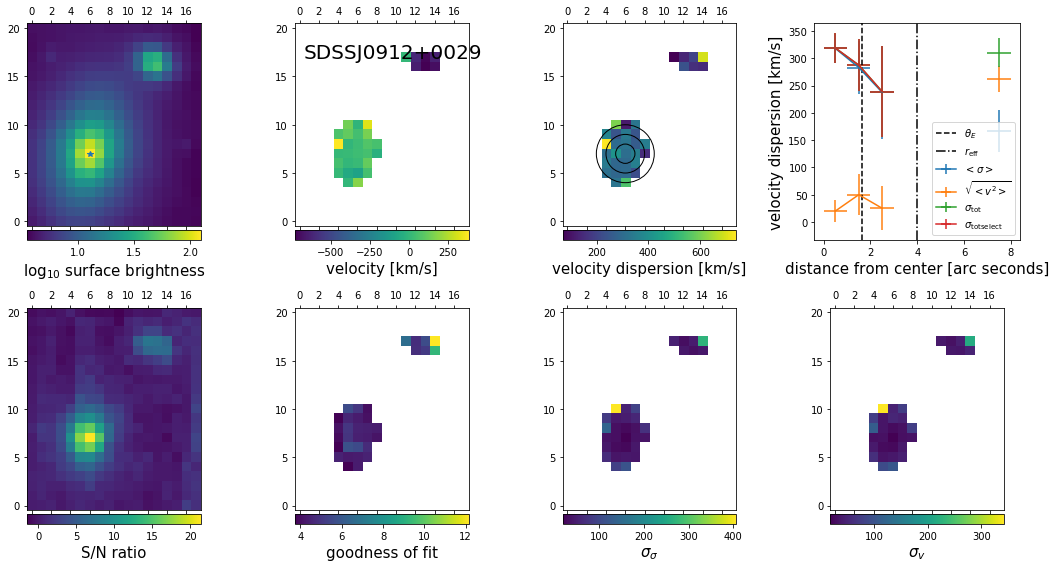

SDSS sigma =  396.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


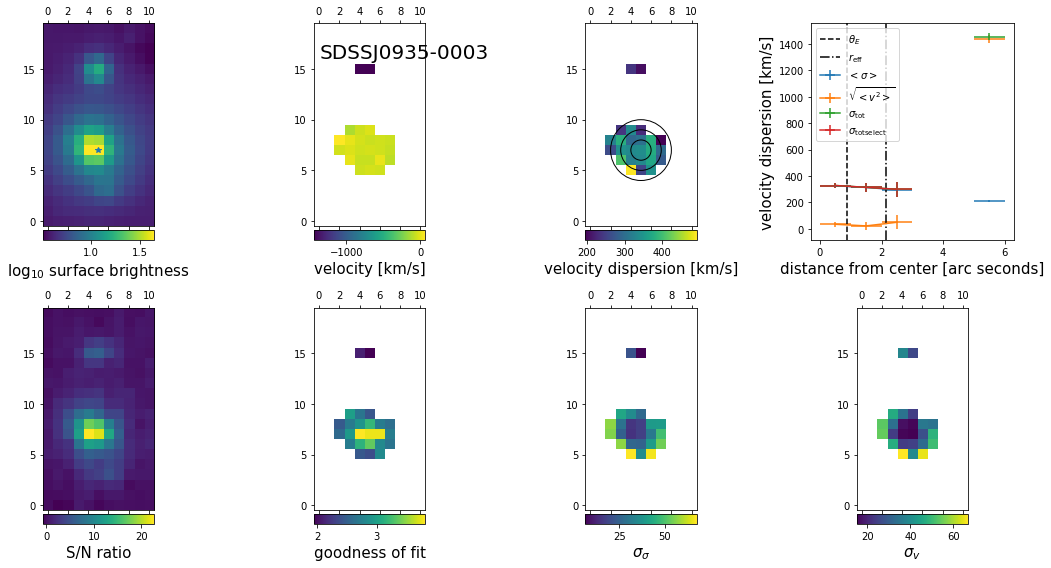

SDSS sigma =  197.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


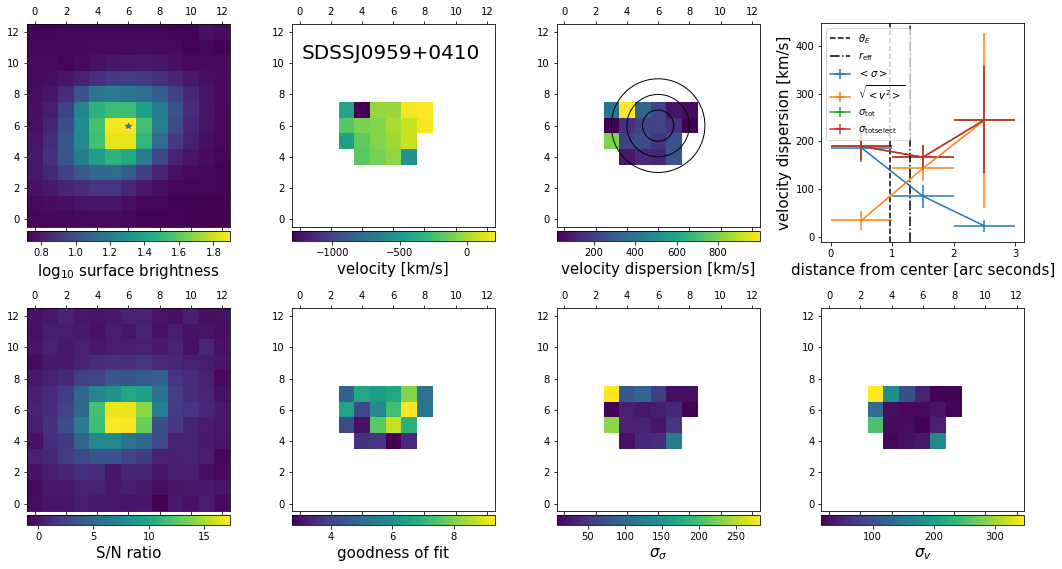

SDSS sigma =  267.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


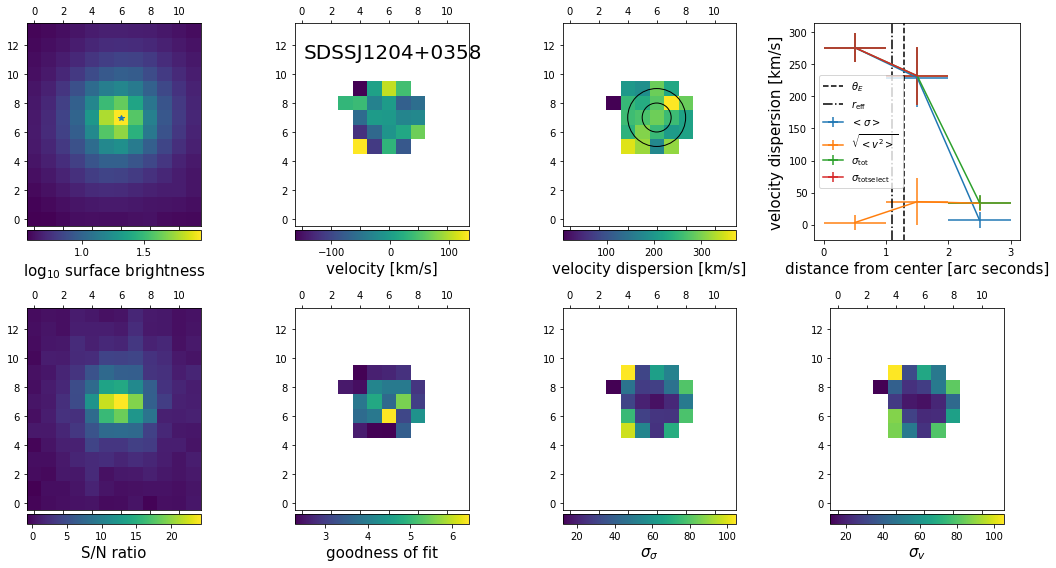

SDSS sigma =  246


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


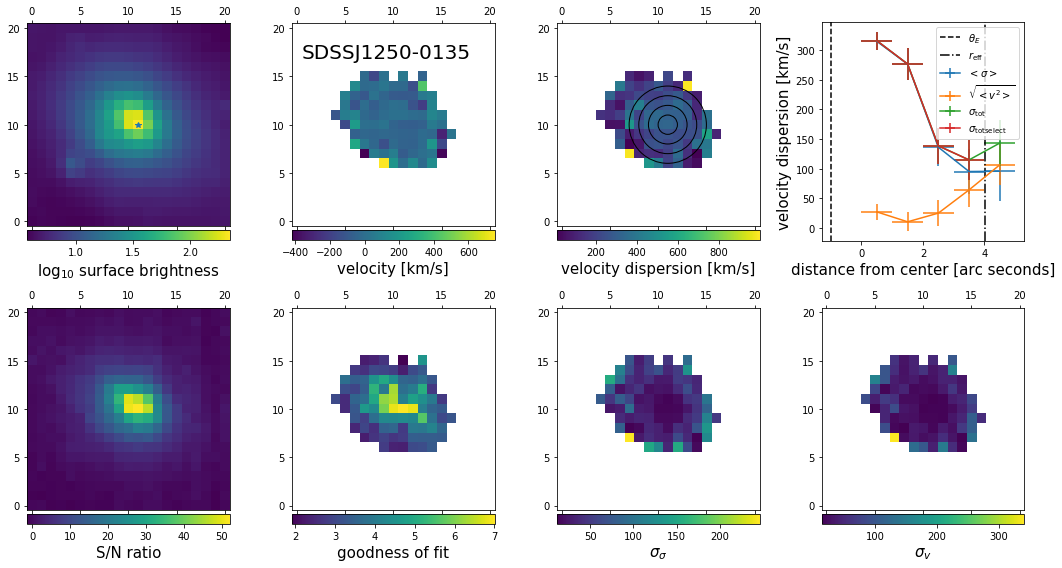

SDSS sigma =  252.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


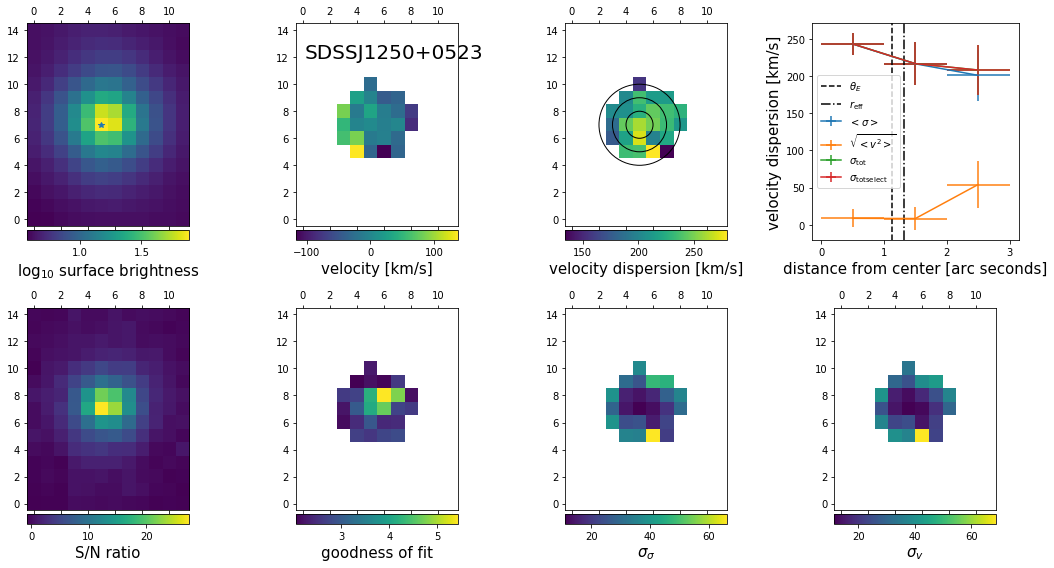

SDSS sigma =  233


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


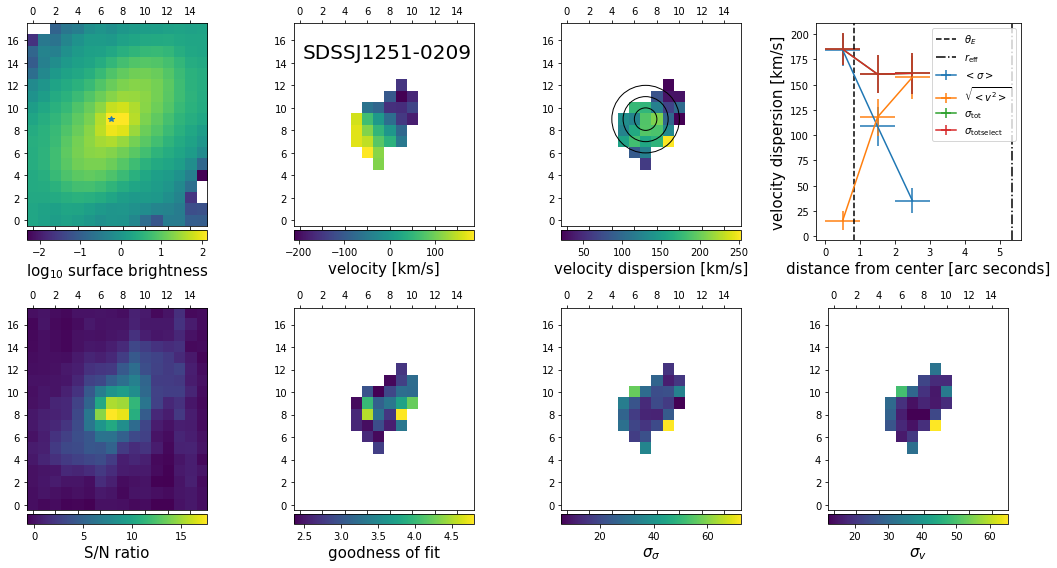

SDSS sigma =  185


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


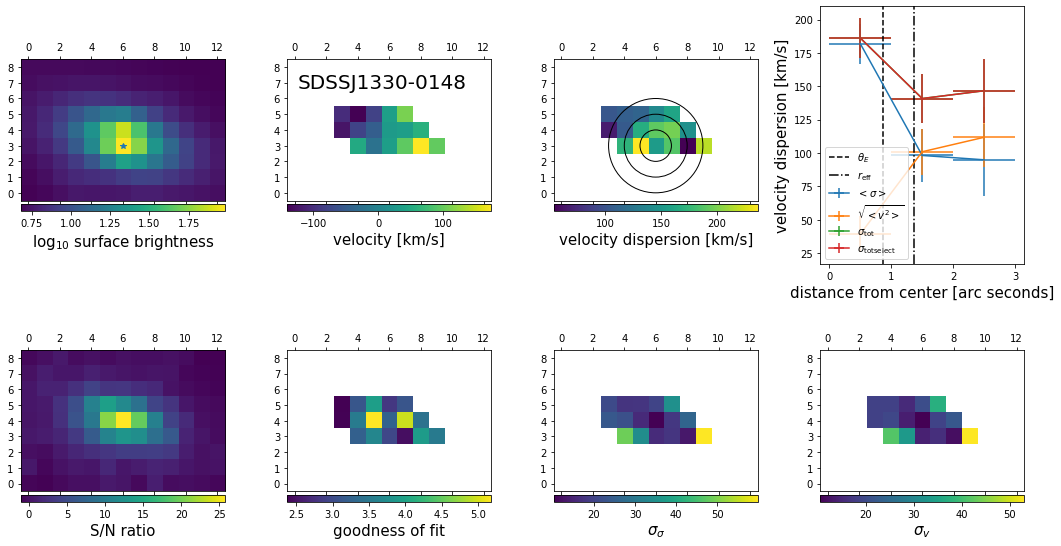

SDSS sigma =  209


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


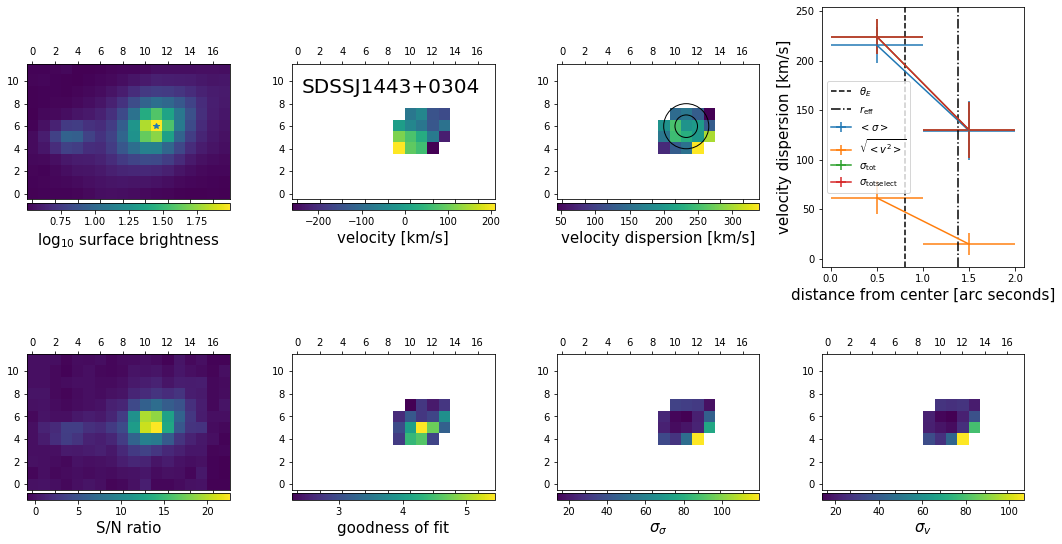

SDSS sigma =  223


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


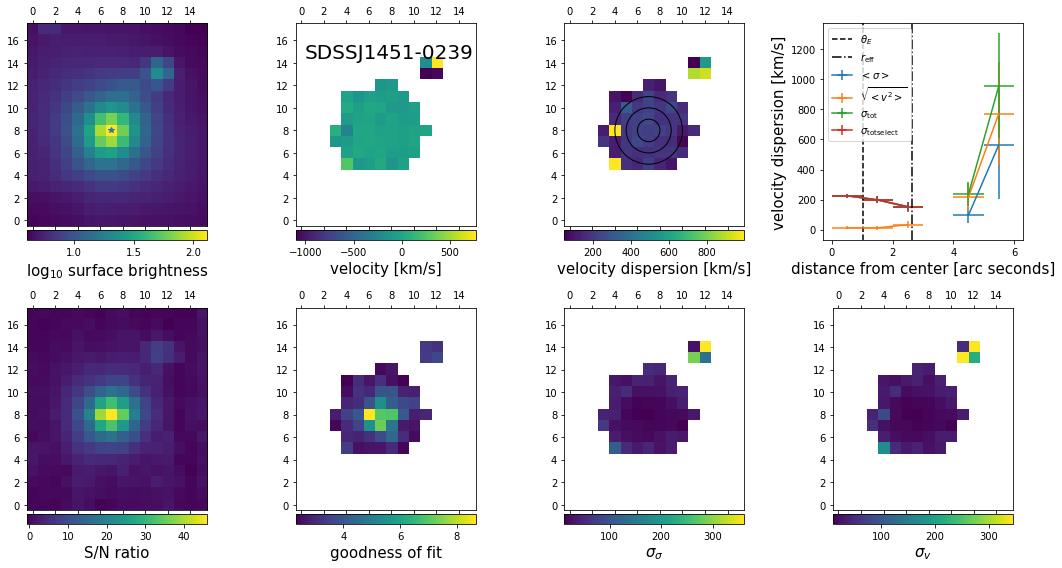

SDSS sigma =  290.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


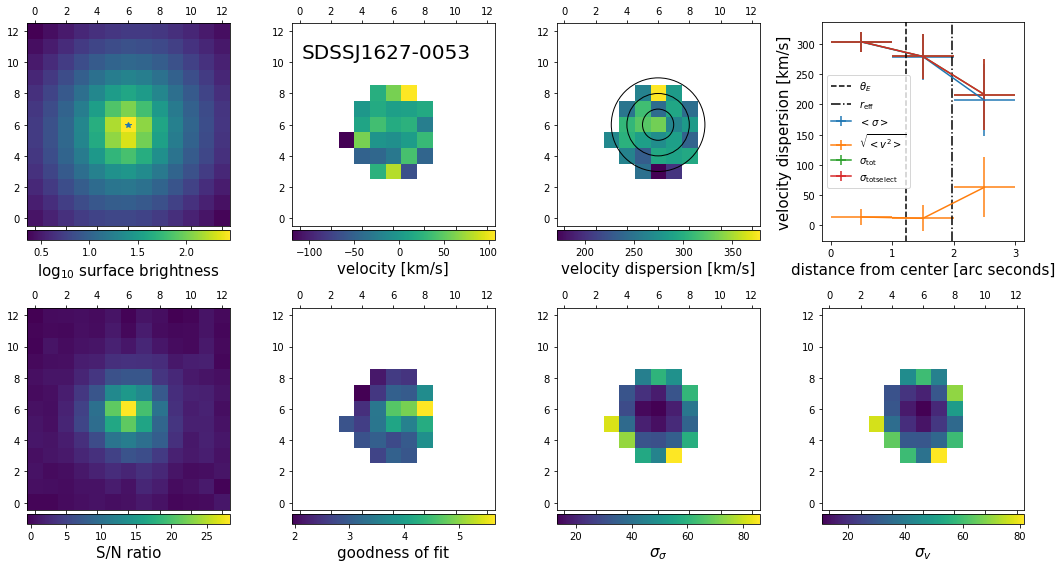

SDSS sigma =  198.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


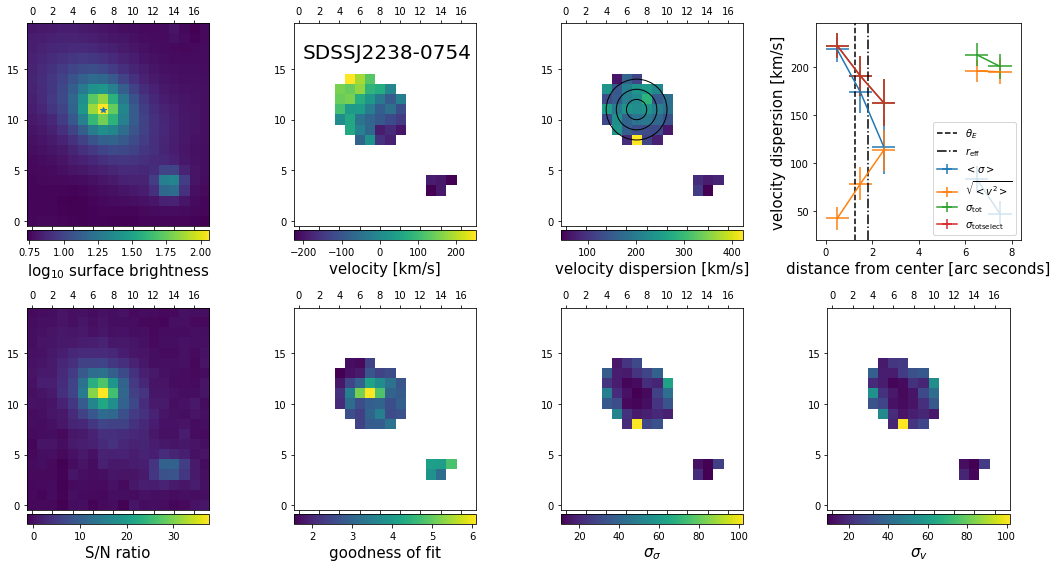

SDSS sigma =  279.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


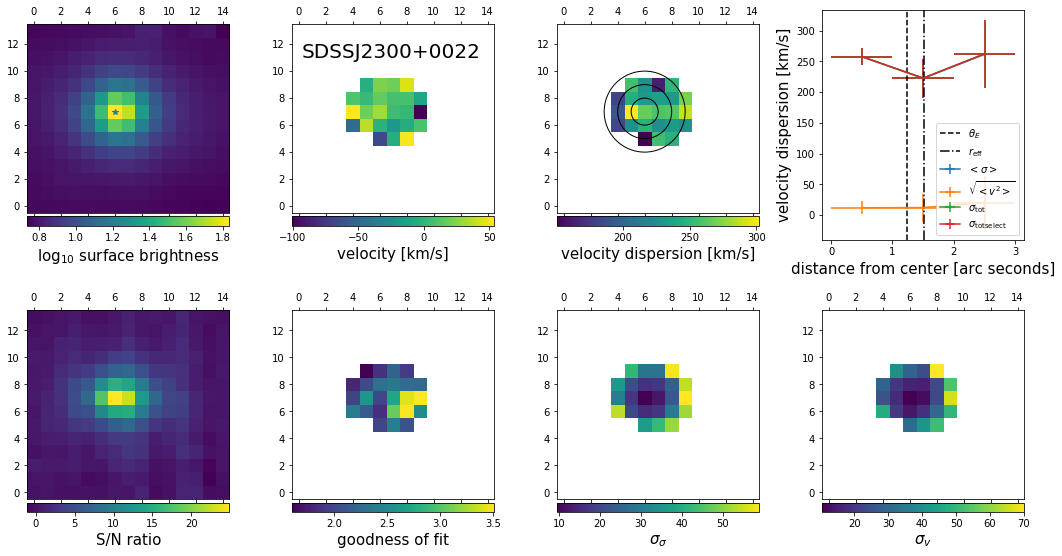

SDSS sigma =  255.0


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encou

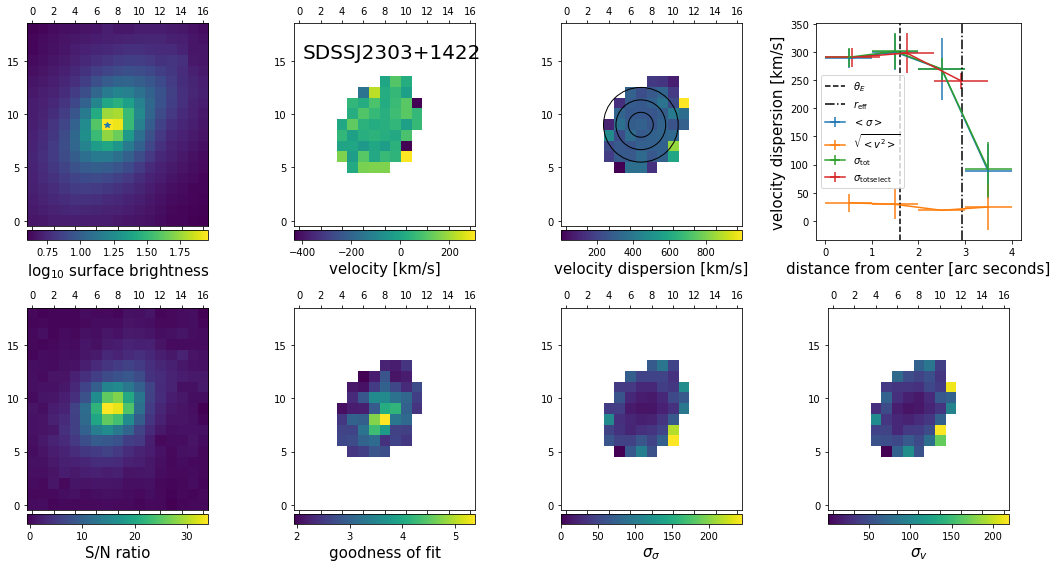

SDSS sigma =  249.0


/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:28: RuntimeWarning: invalid value encountered in double_scalars
  error_weight[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:30: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight[index] * flux[index]) / np.sum(flux[index]))
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:53: RuntimeWarning: invalid value encountered in double_scalars
  error_weight_v2[index] * flux[index])
/Users/sibirrer/Software/hierarc/hierarc/Util/ifu_util.py:55: RuntimeWarning: invalid value encountered in double_scalars
  weight_r.append(np.sum(error_weight_v2[index] * flux[index]) / np.sum(flux[index]))


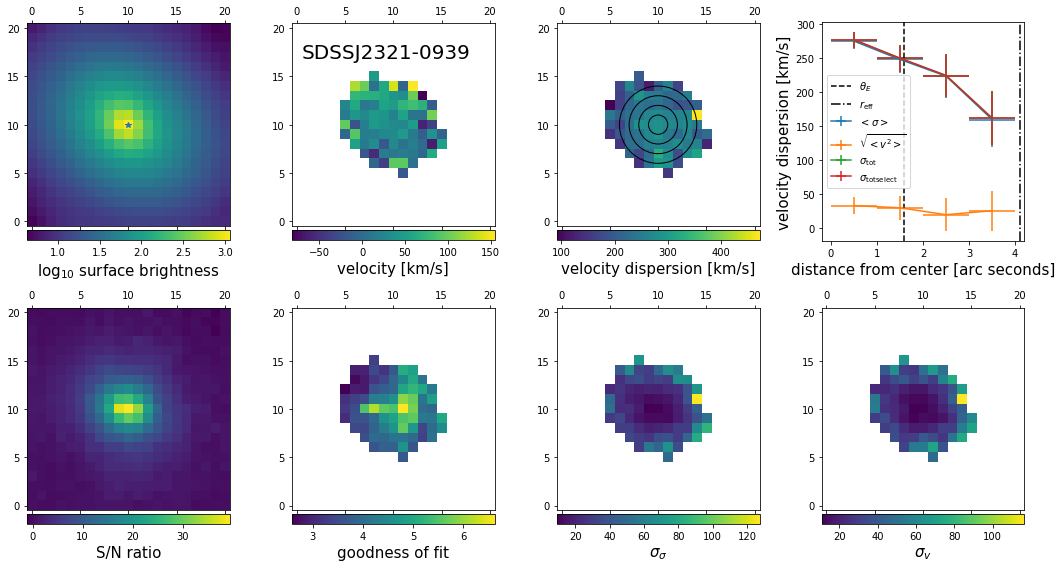

In [4]:
r_bins = np.linspace(0, 8, 9)


with open(file_name_catalogue, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if float(row['IFU']) == 1:
                name = row['name']
                theta_E = float(row['theta_E'])
                r_eff = float(row['r_eff'])
                fiber_scale = float(row['fiber_scale'])
                data_name = str(row['ifu_file_name'])
                file_name = os.path.join(path2ifu, data_name)
                r_bins_2 = np.linspace(0, float(row['r_max']), float(row['n_bin']) + 1)
                print('SDSS sigma = ', row['sigma_v'])
                display_map(file_name, theta_E, r_eff, r_bins=r_bins, 
                            fiber_scale=fiber_scale, save_plot=True, r_bins_2=r_bins_2)
